GAMEPLAN:
- Run FVA on SQS+SQE+MVA 'c' and show no flux
- Isolate each alternative pathway individually by knocking out the downstream connection, and see how much flux being carried from each. Graph
- Conclude that MVA doesn't receive flux and find mechanism that causes this
- Run final experiment to confirm

### Setup

In [2]:
import os, sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cobra')

from cobra import io, Model, Solution
from scripts.helpers.model import rxn_in_model, met_in_model, add_single_gene_reaction_pair
from scripts.opt._fba import flux_balance_analysis
from scripts.opt._fva import run_flux_variability_analysis

Our strategy is to incorporate the MVA pathway in the cytosol. However to test if MVA inactivity is a flux issue, we've also made an additional alteration which places the MVA pathway in the chloroplast, and defines necessary transfer reactions for the precursors. Our very first step is to introduce the ergosterol exchange reactions to support flux to ergosterol in both models.

In [13]:
params = {
    'mode': 'auto' # Also 'hetero' or 'mixo'
}

# Gap-filled models
model_mva_c = io.read_sbml_model(f'../data/altered/xmls/MNL_iCre1355_{params['mode']}_GAPFILL/SQS+SQE+MVA.xml')
model_mva_h = io.read_sbml_model(f'../data/altered/xmls/MNL_iCre1355_{params['mode']}_GAPFILL/h/SQS+SQE+MVA.xml')

# Add ergosterol exchange reaction
ERG = "ergosterol_c"
ERGEXCH = "ERGOSTEROLEXCH"
if not rxn_in_model(model_mva_c, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model_mva_c, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )

if not rxn_in_model(model_mva_h, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model_mva_h, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )


# Add orthophosphate sink reaction
ORTHOP = "orthop_c"
EXCHORTHOP = "ORTHOPHOSPHATEEXCH"
if not rxn_in_model(model_mva_c, EXCHORTHOP):
    add_single_gene_reaction_pair(
        model=model_mva_c,
        gene_id="EXCHORTHOP",
        reaction_id=EXCHORTHOP,
        reaction_name="Orthophosphate exchange (assumption)",
        reaction_subsystem="Exchange",
        metabolites=[(-1, ORTHOP)],
        reversible=True
    )

ORTHOPh = ORTHOP.replace('_c', '_h')
if not rxn_in_model(model_mva_h, EXCHORTHOP):
    add_single_gene_reaction_pair(
        model=model_mva_h,
        gene_id="EXCHORTHOP",
        reaction_id=EXCHORTHOP,
        reaction_name="Orthophosphate exchange (assumption)",
        reaction_subsystem="Exchange",
        metabolites=[(-1, ORTHOPh)],
        reversible=True
    )

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


### FVA (Blocked)

In [16]:
fva_c = run_flux_variability_analysis(
    model_mva_c,
    loopless=True,
    pfba_factor=None,
    objectives=['ALT_MVAS'],
    reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
)

# fva_h = run_flux_variability_analysis(
#     model_mva_h,
#     loopless=True,
#     pfba_factor=None,
#     objectives=['ALT_MVAS'],
#     reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
# )

print(f"Minimum flux for Cytosolic MVA: {fva_c.loc['ALT_MVAD', 'minimum']:.6f} | Maximum: {fva_c.loc['ALT_MVAD', 'maximum']:.6f}")
# print(f"Minimum flux for Chloroplast MVA: {fva_h.loc['ALT_MVAD', 'minimum']:.6f} | Maximum: {fva_h.loc['ALT_MVAD', 'maximum']:.6f}")

# Display full FVA results
print("\nFull FVA Results - Cytosolic MVA:")
print(fva_c)
# print("\nFull FVA Results - Chloroplast MVA:")
# print(fva_h)

Minimum flux for Cytosolic MVA: 0.413793 | Maximum: 0.413793

Full FVA Results - Cytosolic MVA:
           minimum   maximum
ALT_MVAS  0.413793  0.413793
ALT_MVAD  0.413793  0.413793
ALT_MVAE  0.413793  0.413793
ALT_PMK   0.413793  0.413793
ALT_MVK   0.413793  0.413793
ALT_IDLI  0.000000  0.137931


### FVA (Acetyl-CoA)

See if the precursors of MVA can receive flux. The reactions that produce Acetyl-CoA (and thus Acetoacetyl-CoA):
- BCACT
- ATPCS
- ACS
- MCDC
- ACALD

In [12]:
accoa_rxns = ['ACALD', 'BCACT', 'ACS', 'MCDC', 'ATPCS']
aacoa_rxns = ['HBCO', 'ACACT']
fva_c = run_flux_variability_analysis(
    model_mva_c,
    loopless=True,
    pfba_factor=None,
    objectives=accoa_rxns,
    reactions=accoa_rxns + aacoa_rxns
)

# Display full FVA results
print("Full FVA Results - Cytosolic MVA:")
print(fva_c)

Full FVA Results - Cytosolic MVA:
         minimum       maximum
ACALD   5.000000  5.000000e+00
BCACT   0.000000 -2.617539e-17
ACS     0.000000  1.881526e-14
MCDC    0.000000  7.413021e-14
ATPCS  22.683734  2.268373e+01
HBCO    0.000000  0.000000e+00
ACACT   0.000000  2.085451e-13


Upon realizing that MVA is not able to receive flux in both models, we've decided to study the knockout on both models and observe how much flux each competitive pathway can support. This leads us to the next experiment

### FVA (Knock-out)

Following the previous results, we isolate each competing pathway and MVA to see how much flux they can support when optimized for ergosterol. This will show us if flux through MVA is a model issue or is the final result.

MEP pathway can be connected to the sterol synthesis pathway through 3 exchange reactions: FRDPth, GRDPth, and IPDPth. All of these are post-MEP, and the only difference is where the sequence of reactions Geranyl Diphosphate Synthase and Farnesyl Diphosphate Synthase would take place (both can happen in either chloroplast or cytosol).

In [6]:
def format_name(name: str):
    
    if name == ERGEXCH: return "ERGEXCH"
    return "PATH/RXN"

def fba_knockout(m: Model, chloroplast: bool):
    """
    Perform flux balance analysis (FBA) knockout simulations.
    """

    # Save path for temporary model constructs for fluxer analysis
    save_path = os.path.join('.', 'temp', 'mva')
    os.makedirs(save_path, exist_ok=True)

    # Model temp
    temps = {}

    # Isolation strategy
    knockouts_res = {} # Results
    alt = ['FRDPth', 'IPDPth', 'GRDPth', 'ALT_MVAD'] # Cut-off reactions of competitive pathways
    if chloroplast:
        alt = ['CMK', 'ALT_MVAD']

    for rid in alt:

        temp = m.copy()

        for other in alt:
            if other == rid: continue
            rxn = temp.reactions.get_by_id(other)
            rxn.lower_bound = 0
            rxn.upper_bound = 0

        fva = run_flux_variability_analysis(
            temp,
            loopless=True,
            pfba_factor=None,
            objectives=[ERGEXCH],
            reactions=[
                # 'ALT_MVAS',
                # 'ALT_MVAD',
                # 'ALT_MVAE',
                # 'ALT_PMK',
                # 'ALT_MVK',
                # 'ALT_IDLI',
                # 'GPPS',
                # 'FPPS',
                # 'SS',
                # 'ALT_SQS2',
                'Biomass_Chlamy_auto',
                ERGEXCH
            ] + alt
        )

        io.write_sbml_model(temp, os.path.join(save_path, 'temp.xml'))

        knockouts_res[rid] = fva.loc[[rid,ERGEXCH],'maximum'].rename(index=format_name)
        temps[rid] = temp

    return knockouts_res, temps

res_c, temps_c = fba_knockout(model_mva_c, chloroplast=False)
res_h, temps_h = fba_knockout(model_mva_h, chloroplast=True)

results = {
    'FRDPth': res_c['FRDPth'],
    'IPDPth': res_c['IPDPth'],
    'GRDPth': res_c['GRDPth'],
    'MVA (Cytosolic)': res_c['ALT_MVAD'],
    'MVA (Chloroplast)': res_h['ALT_MVAD']
}

temps = {
    'FRDPth': temps_c['FRDPth'],
    'IPDPth': temps_c['IPDPth'],
    'GRDPth': temps_c['GRDPth'],
    'MVA (Cytosolic)': temps_c['ALT_MVAD'],
    'MVA (Chloroplast)': temps_h['ALT_MVAD']
}

Creating heatmap for flux ranges (objective only)...


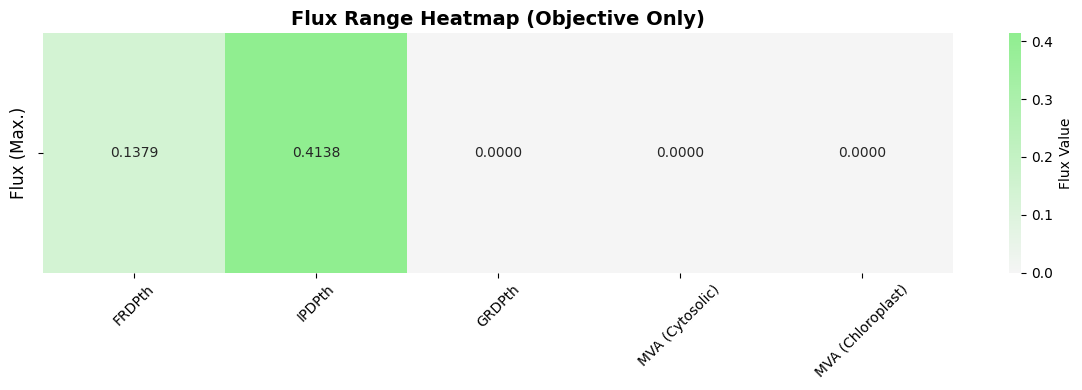

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

def create_result_heatmap(result_dict, title="Flux Range Heatmap", figsize=(10, 6), cmap=None, annot=True, show_objective_only=False):
    """
    Create a heatmap visualization from a result object with keys as columns
    and Series values (with 2 values each) as rows.
    
    Parameters:
    -----------
    result_dict : dict
        Dictionary where keys become columns and values are pd.Series with 2 values
    title : str
        Title for the heatmap
    figsize : tuple
        Figure size (width, height)
    cmap : matplotlib colormap or None
        Colormap for the heatmap
    annot : bool
        Whether to annotate cells with values
    show_objective_only : bool
        If True, only show the objective row (not ergosterol)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Custom colormap: white to #EE90EE
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['#F5F5F5', '#90EE90'])
    
    # Convert result dictionary to DataFrame
    data_matrix = []
    column_names = list(result_dict.keys())
    
    # Get the index names from the first Series (assuming all have same structure)
    first_series = list(result_dict.values())[0]
    row_names = first_series.index.tolist()
    
    # Optionally filter to only show the objective row (not ergosterol)
    if show_objective_only:
        # Remove PATH/RXN label if present
        if row_names[0] == 'PATH/RXN':
            row_names = ['']
        else:
            row_names = [row_names[0]]
        for col_name in column_names:
            series_data = result_dict[col_name]
            data_matrix.append([series_data.values[0]])
    else:
        for col_name in column_names:
            series_data = result_dict[col_name]
            data_matrix.append(series_data.values)
    
    # Transpose to get proper orientation (rows = series indices, columns = dict keys)
    data_matrix = np.array(data_matrix).T
    
    # Create DataFrame for easier handling
    df = pd.DataFrame(data_matrix, index=row_names, columns=column_names)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(df, 
                annot=annot, 
                cmap=cmap, 
                fmt='.4f',
                cbar_kws={'label': 'Flux Value'},
                ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Flux (Max.)', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig, ax

# Example usage with your result objects:
print("Creating heatmap for flux ranges (objective only)...")

save_path = os.path.join('..','results','bench','mva')
os.makedirs(save_path, exist_ok=True)
fig, ax = create_result_heatmap(results, 
                                title="Flux Range Heatmap (Objective Only)", 
                                figsize=(12, 4),
                                cmap=None,
                                annot=True,
                                show_objective_only=True)
fig.savefig(os.path.join(save_path, "flux_range_heatmap_objective.png"), dpi=300)
plt.show()

The above heatmap confirms that despite being isolated, MVA cannot activate and prodoce the precursors essential to ergosterol. Inclined to think this is not a model issue, as upstreeam and downstream of MVA there's flux, we've investigated the mechanism that may cause this behaviour. We've looked into the flow of flux for the precursors of MVA and studied what mechanisms they bind to. 

In [30]:
temp = temps['MVA (Cytosolic)'].copy()

for rxn in temp.reactions:
    
    if rxn.subsystem != 'Fatty acid metabolism': continue
    rxn.bounds = (0, 0)

fva = run_flux_variability_analysis(
    model=temp,
    loopless=True,
    pfba_factor=None,
    objectives=[ERGEXCH],
    reactions=[ERGEXCH]
)

fva

,minimum,maximum
ERGOSTEROLEXCH,0.0,6.144634e-33


In [5]:
from cobra import Metabolite, Reaction

temp = temps['MVA (Cytosolic)'].copy()
AACOA = temp.metabolites.get_by_id('aacoa_c')
ACCOA = temp.metabolites.get_by_id('accoa_c')

# Introduce medium metabolites
newAACOA = Metabolite(
    id='aacoa_e',
    name=AACOA.name,
    compartment='e',
    charge=AACOA.charge,
    formula=AACOA.formula
)
newACCOA = Metabolite(
    id='aacoa_e',
    name=ACCOA.name,
    compartment='e',
    charge=ACCOA.charge,
    formula=ACCOA.formula
)
temp.add_metabolites([newAACOA, newACCOA])

# Produce and exchange new medium: Acetyl-CoA
add_single_gene_reaction_pair(
    temp,
    gene_id='ACCOA_EXCH',
    reaction_id='Ex_accoa_e',
    reaction_name='Acetyl-CoA Exchange: Uptake',
    reaction_subsystem='Exchange',
    metabolites=[(-1, 'accoa_e'), (1, 'accoa_c')],
    reversible=False
)

add_single_gene_reaction_pair(
    temp,
    gene_id='ACCOA_UPTAKE',
    reaction_id='P_accoa_e',
    reaction_name='Acetyl-CoA Introduction',
    reaction_subsystem='Exchange',
    metabolites=[(1, 'accoa_e')],
    reversible=True
)

# Produce and exchange new medium: Acetoacetyl-CoA
add_single_gene_reaction_pair(
    temp,
    gene_id='AACOA_EXCH',
    reaction_id='Ex_aacoa_e',
    reaction_name='Acetoacetyl-CoA Exchange: Uptake',
    reaction_subsystem='Exchange',
    metabolites=[(-1, 'aacoa_e'), (1, 'aacoa_c')],
    reversible=False
)

add_single_gene_reaction_pair(
    temp,
    gene_id='AACOA_UPTAKE',
    reaction_id='P_aacoa_e',
    reaction_name='Acetoacetyl-CoA Uptake',
    reaction_subsystem='Exchange',
    metabolites=[(1, 'aacoa_e')],
    reversible=True
)

# Run flux variability analysis
fva = run_flux_variability_analysis(
    model=temp,
    loopless=True,
    pfba_factor=None,
    objectives=['Ex_aacoa_e', 'Ex_accoa_e'],
    reactions=['ALT_MVAD', 'Ex_aacoa_e', 'Ex_accoa_e', 'SS', ERGEXCH]
)

fva

NameError: name 'temps' is not defined

(REALIZED THAT FPPS DOESN'T BEHAVE PROPERLY & SO COPY OVER INFORMATION FROM FPPSh)

In [20]:
temp = model_mva_c.copy()

ref = temp.reactions.get_by_id('FPPSh')
target = temp.reactions.get_by_id('FPPS')
h_c = temp.metabolites.get_by_id('h_c')

target.add_metabolites({h_c: 1.0})

print(ref.metabolites)
print(target.metabolites)

fva = run_flux_variability_analysis(
    temp,
    loopless=True,
    pfba_factor=None,
    objectives=['ALT_MVAD', 'FPPS'],
    reactions=['FPPS', 'ALT_MVAD', 'ALT_MVAS', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI', ERGEXCH, 'Biomass_Chlamy_auto']
)

{<Metabolite grdp_h at 0x1d36a259430>: -1.0, <Metabolite ipdp_h at 0x1d36a25ac00>: -1.0, <Metabolite ppi_h at 0x1d36a28bc20>: 1.0, <Metabolite frdp_h at 0x1d36a258080>: 1.0, <Metabolite h_h at 0x1d36a2597f0>: 1.0}
{<Metabolite grdp_c at 0x1d36a259400>: -1.0, <Metabolite ipdp_c at 0x1d36a25abd0>: -1.0, <Metabolite ppi_c at 0x1d36a28bbf0>: 1.0, <Metabolite frdp_c at 0x1d36a258050>: 1.0, <Metabolite h_c at 0x1d36a259730>: 1.0}


In [21]:
fva

,minimum,maximum
FPPS,0.137931,1.379310e-01
ALT_MVAD,0.000000,0.000000e+00
ALT_MVAS,0.000000,-1.464670e-31
ALT_MVAE,0.000000,-1.464670e-31
ALT_PMK,0.000000,-1.464670e-31
ALT_MVK,0.000000,-1.464670e-31
ALT_IDLI,0.000000,1.379310e-01
ERGOSTEROLEXCH,0.068966,6.896552e-02
Biomass_Chlamy_auto,0.000000,3.608259e-16


### FVA (Repaired)

In [5]:
temp = model.copy()

# Acetyl_CoA_c = temp.metabolites.get_by_id("accoa_c")
# Acetyl_CoA_h = temp.metabolites.get_by_id("accoa_h")

FPPS = temp.reactions.get_by_id('FPPS')
mets = FPPS.metabolites

add_single_gene_reaction_pair(
    model=temp,
    gene_id="FPPS_ATTEMPT",
    reaction_id='FPPS_NEW',
    reaction_name="Farnesyl pyrophosphate synthase (manual)",
    reaction_subsystem="Biosynthesis of steroids",
    metabolites=[ (k, v.id) for v, k in mets.items() ],
    reversible=False
)

FPPS.lower_bound = 0
FPPS.upper_bound = 0

fva = run_flux_variability_analysis(
    model=temp,
    loopless=True,
    pfba_factor=None,
    objectives=['ALT_MVAS'],
    reactions=['ALT_MVAS', 'ALT_MVAD', 'ALT_MVAE', 'ALT_PMK', 'ALT_MVK', 'ALT_IDLI']
)

fva

,minimum,maximum
ALT_MVAS,0.0,-5.349016e-31
ALT_MVAD,0.0,0.000000e+00
ALT_MVAE,0.0,-5.349016e-31
ALT_PMK,0.0,0.000000e+00
ALT_MVK,0.0,-2.790923e-29
ALT_IDLI,0.0,1.379310e-01
